### Install necessary packages

In [1]:
!pip install -q ftfy regex tqdm scikit-learn scikit-image
!pip install -q git+https://github.com/openai/CLIP.git


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


### Download and extract the datasets

In [2]:
!gdown --fuzzy https://drive.google.com/file/d/1nfictDVptrdDwRNaxsBx0UIlP7tpDsN_/view?usp=sharing

zsh:1: no matches found: https://drive.google.com/file/d/1nfictDVptrdDwRNaxsBx0UIlP7tpDsN_/view?usp=sharing


In [3]:
!mkdir datasets
!tar -xvf imagenet-a.tar -C datasets

mkdir: cannot create directory ‘datasets’: File exists
tar: imagenet-a.tar: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


### Import necessary libraries

In [4]:
import clip
import torch
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import skimage
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as v2
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from torchvision import transforms
from tqdm import tqdm

from PIL import Image
import random

try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/16', DEVICE)

In [5]:
class ImageNetA(Dataset):
    def __init__(self, root_dir='datasets/imagenet-a', transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Load class code to name mapping from README.txt
        self.class_code_to_name = self._load_class_mapping(os.path.join(root_dir, 'README.txt'))

        # Map class codes to integer labels
        self.class_codes = sorted([
            d for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d)) and d in self.class_code_to_name
        ])
        self.class_code_to_idx = {code: idx for idx, code in enumerate(self.class_codes)}

        # Collect all image paths and labels
        self.samples = []
        for class_code in self.class_codes:
            class_folder = os.path.join(root_dir, class_code)
            for fname in os.listdir(class_folder):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    path = os.path.join(class_folder, fname)
                    label = self.class_code_to_idx[class_code]
                    self.samples.append((path, label))

    def _load_class_mapping(self, readme_path):
        mapping = {}
        with open(readme_path, 'r') as f:
            lines = f.readlines()[12:]  # Skip the first 12 lines
            for line in lines:
                parts = line.strip().split(' ', 1)
                if len(parts) == 2:
                    code, name = parts
                    mapping[code] = name
        return mapping

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


### Import the Dataset

In [6]:
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer

_tokenizer = _Tokenizer()

In [7]:
class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection

    def forward(self, prompts, tokenized_prompts):
        x = prompts + self.positional_embedding
        x = x.permute(1, 0, 2)  # [batch_size, n_ctx, transformer.width] -> [n_ctx, batch_size, transformer.width]
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # [n_ctx, batch_size, transformer.width] -> [batch_size, n_ctx, transformer.width]
        x = self.ln_final(x)

        # Take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.text_projection

        return x

In [8]:
class PromptLearner(nn.Module):
    def __init__(self, clip_model, classnames, n_ctx, ctx_init, class_token_position, csc=False):
        super().__init__()
        n_cls = len(classnames)
        ctx_dim = clip_model.ln_final.weight.shape[0]
        clip_imsize = clip_model.visual.input_resolution

        # Use given words to initialize context vectors
        if ctx_init:
            ctx_init = ctx_init.replace("_", " ")
            n_ctx = len(ctx_init.split(" "))
            prompt = clip.tokenize(ctx_init).to(clip_model.token_embedding.weight.device)
            with torch.no_grad():
                embedding = clip_model.token_embedding(prompt)
            ctx_vectors = embedding[0, 1 : 1 + n_ctx, :]
            prompt_prefix = ctx_init
        else:
            if csc:
                print("Initializing class-specific contexts")
                ctx_vectors = torch.empty(n_cls, n_ctx, ctx_dim)
            else:
                print("Initializing a generic context")
                ctx_vectors = torch.empty(n_ctx, ctx_dim)

            torch.nn.init.normal_(ctx_vectors, std=0.02)
            prompt_prefix = " ".join(["X"] * n_ctx)

        print(f"Initial context: '{prompt_prefix}'")
        print(f"Number of context words (tokens): {n_ctx}")

        # These are the `prompts` we want to optimize
        self.ctx = nn.Parameter(ctx_vectors)

        print(classnames)
        classnames = [name.replace("_", " ") for name in classnames]
        name_lens = [len(_tokenizer.encode(name)) for name in classnames]
        prompts = [prompt_prefix + " " + name + "." for name in classnames]

        # print("+++")
        # print("Prompts:")
        # for p in prompts:
        #     print(p)
        # print("+++")

        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]).to(clip_model.token_embedding.weight.device)

        with torch.no_grad():
            embedding = clip_model.token_embedding(tokenized_prompts)

        # These token vectors will be saved when in save_model(),
        # but they should be ignored in load_model() as we want to use
        # those computed using the current class names
        self.register_buffer("token_prefix", embedding[:, :1, :])  # SOS
        self.register_buffer("token_suffix", embedding[:, 1 + n_ctx :, :])  # CLS, EOS

        self.n_cls = n_cls
        self.n_ctx = n_ctx
        self.tokenized_prompts = tokenized_prompts
        self.name_lens = name_lens
        self.class_token_position = class_token_position

    def forward(self):
        prefix = self.token_prefix
        suffix = self.token_suffix
        ctx = self.ctx

        # If CoOp, expand the ctx for all classes
        if ctx.dim() == 2:
            ctx = ctx.unsqueeze(0).expand(self.n_cls, -1, -1)

        if self.class_token_position == "end":
            prompts = torch.cat(
                [
                    prefix,  # (n_cls, 1, dim)
                    ctx,     # (n_cls, n_ctx, dim)
                    suffix,  # (n_cls, *, dim)
                ],
                dim=1,
            )

        elif self.class_token_position == "middle":
            half_n_ctx = self.n_ctx // 2
            prompts = []
            for i in range(self.n_cls):
                name_len = self.name_lens[i]
                prefix_i = prefix[i : i + 1, :, :]
                class_i = suffix[i : i + 1, :name_len, :]
                suffix_i = suffix[i : i + 1, name_len:, :]
                ctx_i_half1 = ctx[i : i + 1, :half_n_ctx, :]
                ctx_i_half2 = ctx[i : i + 1, half_n_ctx:, :]
                prompt = torch.cat(
                    [
                        prefix_i,     # (1, 1, dim)
                        ctx_i_half1,  # (1, n_ctx//2, dim)
                        class_i,      # (1, name_len, dim)
                        ctx_i_half2,  # (1, n_ctx//2, dim)
                        suffix_i,     # (1, *, dim)
                    ],
                    dim=1,
                )
                prompts.append(prompt)
            prompts = torch.cat(prompts, dim=0)

        elif self.class_token_position == "front":
            prompts = []
            for i in range(self.n_cls):
                name_len = self.name_lens[i]
                prefix_i = prefix[i : i + 1, :, :]
                class_i = suffix[i : i + 1, :name_len, :]
                suffix_i = suffix[i : i + 1, name_len:, :]
                ctx_i = ctx[i : i + 1, :, :]
                prompt = torch.cat(
                    [
                        prefix_i,  # (1, 1, dim)
                        class_i,   # (1, name_len, dim)
                        ctx_i,     # (1, n_ctx, dim)
                        suffix_i,  # (1, *, dim)
                    ],
                    dim=1,
                )
                prompts.append(prompt)
            prompts = torch.cat(prompts, dim=0)

        else:
            raise ValueError

        return prompts

In [9]:
class OurCLIP(nn.Module):
    def __init__(self, classnames, n_ctx, ctx_init, class_token_position, csc=False):
        super().__init__()
        clip_model, _ = clip.load("ViT-B/16")
        # clip_model = clip_model.cpu()
        clip_model = clip_model.float()

        self.prompt_learner = PromptLearner(clip_model, classnames, n_ctx, ctx_init, class_token_position, csc=csc)
        self.tokenized_prompts = self.prompt_learner.tokenized_prompts
        self.image_encoder = clip_model.visual
        self.text_encoder = TextEncoder(clip_model)
        self.logit_scale = clip_model.logit_scale

    def forward(self, image):
        image_features = self.image_encoder(image)

        prompts = self.prompt_learner()
        tokenized_prompts = self.tokenized_prompts
        text_features = self.text_encoder(prompts, tokenized_prompts)

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        logit_scale = self.logit_scale.exp()
        logits = logit_scale * image_features @ text_features.t()

        return logits

### Utility functions

In [24]:
import matplotlib.pyplot as plt
import torchvision


def show_augmented_images(dataset, num_images=16, label = "augmented"):
    """
    Show a grid of augmented images from the dataset.
    num_images must be a perfect square (e.g., 4, 9, 16, 25, 36, ...)
    """
    assert int(
        num_images ** 0.5) ** 2 == num_images, "num_images must be a perfect square"

    images = []
    for i in range(num_images):
        img_tensor, _ = dataset[i]
        images.append(img_tensor)

    # Make a grid of images
    grid = torchvision.utils.make_grid(
        images, nrow=int(num_images ** 0.5), padding=2)
    npimg = grid.numpy()

    # Convert and display
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.title(f'{num_images} Augmented Versions (including original) of {label}')
    plt.show()
    

def show_augmented_images_from_id_list(dataset, id_list, title = ""):
    """
    Show a grid of augmented images from the dataset.
    num_images must be a perfect square (e.g., 4, 9, 16, 25, 36, ...)
    """

    images = []
    for i in id_list:
        img_tensor, _ = dataset[i]
        images.append(img_tensor)

    # Make a grid of images
    grid = torchvision.utils.make_grid(
        images, nrow=int(len(id_list) ** 0.5), padding=2)
    npimg = grid.numpy()

    # Convert and display
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.title(f'{len(id_list)} Augmented Versions: {title}')
    plt.show()


def show_tensor_images(tensor_images):
    """
    Show a grid of augmented images from the dataset.
    num_images must be a perfect square (e.g., 4, 9, 16, 25, 36, ...)
    """

    # Make a grid of images
    grid = torchvision.utils.make_grid(
        tensor_images, nrow=int(len(tensor_images) ** 0.5), padding=2)
    npimg = grid.numpy()

    # Convert and display
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.title(f'{len(tensor_images)} Augmented Versions')
    plt.show()

In [11]:
def select_confident_samples(logits, top_p):
    """
    Select the p-percentile of samples with lowest entropy, i.e. highest confidence.
    """
    assert 0 <= top_p < 1, "The value must be between 0 and 1"
    batch_entropy = -(logits.softmax(1) * logits.log_softmax(1)).sum(1)
    idx = torch.argsort(batch_entropy, descending=False)[
        :int(batch_entropy.size()[0] * top_p)]
    return logits[idx], idx


def compute_avg_entropy(outputs):
    """
    Compute marginal entropy of samples and return the average.
    """
    # To avoid log(0), clamp probabilities to a minimum value
    probs = probs.clamp(min=1e-9)
    entropy = -(probs * probs.log()).sum(dim=1)
    return entropy.mean()

In [12]:
def get_dataset_split(dataset_class,train_percentage=0.5, validation_percentage=0.25):
    # Load data
    dataset = dataset_class("datasets/imagenet-a", preprocess)

    # Create train validation and test samples
    num_samples = len(dataset)
    training_sample = int(num_samples * train_percentage + 1)
    validation_sample = int(num_samples * validation_percentage)
    test_sample = num_samples - training_sample - validation_sample

    training_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [training_sample, validation_sample, test_sample])

    return (training_dataset, validation_dataset, test_dataset)


def get_data(training_dataset, validation_dataset, test_dataset, batch_size=64, transform=None, num_workers=8):
    """
    Load the dataset, split it into train/val/test and return a DataLoader for each.
    """

    if not transform:
        transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])


    # Create a DataLoader
    train_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader

def embed_dataset_classnames(dataset_class, model, templates=["a photo of a {}."]):
    """
    Embed the classnames in the prompt template.
    Return the classnames and the normalized textual features.
    """
    # Create the list of descriptions and tokenize them
    dataset = dataset_class("datasets/imagenet-a", preprocess)
    classnames = dataset.class_code_to_name.values()

    texts_z_views = []
    for template in templates:
        descriptions = [template.format(c) for c in classnames]
        text_tokens = clip.tokenize(descriptions).cuda()

        # Get the normalized textual features
        with torch.no_grad():
            texts_z = model.encode_text(text_tokens).float()
            texts_z /= texts_z.norm(dim=-1, keepdim=True)
            texts_z_views.append(texts_z)

    # Evaluate the mean representation
    texts_z = torch.stack(texts_z_views).mean(dim=0)

    # Renormalise
    texts_z /= texts_z.norm(dim=-1, keepdim=True)

    return classnames, texts_z

In [13]:
def get_optimizer(model, lr, wd, momentum):
    optimizer = torch.optim.SGD([
        {"params": model.parameters()}
    ], lr=lr, weight_decay=wd, momentum=momentum)

    return optimizer

def get_cost_function():
    cost_function = torch.nn.CrossEntropyLoss()
    return cost_function

In [14]:
def log_values(writer, step, loss, accuracy, prefix):
    writer.add_scalar(f"{prefix}/loss", loss, step)
    writer.add_scalar(f"{prefix}/accuracy", accuracy, step)

In [15]:
def training_step(net, data_loader, optimizer, cost_function, device="cuda"):
    """
    Training step (for CoOp).
    """
    samples = 0.0
    cumulative_loss = 0.0
    cumulative_accuracy = 0.0

    # Set the network to training mode
    net.train()

    # Iterate over the training set
    pbar = tqdm(data_loader, desc="Training", position=0, leave=True, total=len(data_loader))
    for batch_idx, (inputs, targets) in enumerate(data_loader):
        # Load data into GPU
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = net(inputs)

        # Loss computation
        loss = cost_function(outputs, targets)

        # Backward pass
        loss.backward()

        # Parameters update
        optimizer.step()

        # Gradients reset
        optimizer.zero_grad()

        # Fetch prediction and loss value
        samples += inputs.shape[0]
        cumulative_loss += loss.item()
        _, predicted = outputs.max(dim=1) # max() returns (maximum_value, index_of_maximum_value)

        # Compute training accuracy
        cumulative_accuracy += predicted.eq(targets).sum().item()

        pbar.set_postfix(train_loss=loss.item(), train_acc=cumulative_accuracy / samples * 100)
        pbar.update(1)

    return cumulative_loss / samples, cumulative_accuracy / samples * 100

def test_step(net, data_loader, cost_function, device="cuda"):
    samples = 0.0
    cumulative_loss = 0.0
    cumulative_accuracy = 0.0

    # Set the network to evaluation mode
    net.eval()

    # Disable gradient computation (we are only testing, we do not want our model to be modified in this step!)
    pbar = tqdm(data_loader, desc="Testing", position=0, leave=True, total=len(data_loader))
    with torch.no_grad():
        # Iterate over the test set
        for batch_idx, (inputs, targets) in enumerate(data_loader):
            # Load data into GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = net(inputs)

            # Loss computation
            loss = cost_function(outputs, targets)

            # Fetch prediction and loss value
            samples += inputs.shape[0]
            cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
            _, predicted = outputs.max(1)

            # Compute accuracy
            cumulative_accuracy += predicted.eq(targets).sum().item()

            pbar.set_postfix(test_acc=cumulative_accuracy / samples * 100)
            pbar.update(1)

    return cumulative_loss / samples, cumulative_accuracy / samples * 100

### Main

In [16]:
def main_coop(
    net,
    dataset_splits,
    batch_size=16,
    learning_rate=0.002,
    weight_decay=0.0005,
    momentum=0.9,
    epochs=2,
    run_name="exp1",
):
    """
    @param: dataset_class
    @param: dataset_splits tuple that contains (training, validation, test) """
    
    # Create a logger for the experiment
    writer = SummaryWriter(log_dir=f"runs/{run_name}")

    # Get dataloaders
    train_loader, val_loader, test_loader = get_data(dataset_splits[0],dataset_splits[1],dataset_splits[2], transform=preprocess, batch_size=batch_size)


    print("Turning off gradients in both the image and the text encoder")
    for name, param in net.named_parameters():
        if "prompt_learner" not in name:
            param.requires_grad_(False)

    print(f"Total parameters: {sum(p.numel() for p in net.parameters()):,}")
    print(f"Total trainable parameters: {sum(p.numel() for p in net.parameters() if p.requires_grad):,}")

    # Instantiate the optimizer
    optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

    # Define the cost function
    cost_function = get_cost_function()

    # Computes evaluation results before training
    print("Before training:")
    train_loss, train_accuracy = test_step(net, train_loader, cost_function)
    val_loss, val_accuracy = test_step(net, val_loader, cost_function)
    test_loss, test_accuracy = test_step(net, test_loader, cost_function)

    # Log to TensorBoard
    log_values(writer, -1, train_loss, train_accuracy, "train")
    log_values(writer, -1, val_loss, val_accuracy, "validation")
    log_values(writer, -1, test_loss, test_accuracy, "test")

    print(f"\tTraining loss {train_loss:.5f}, Training accuracy {train_accuracy:.2f}")
    print(f"\tValidation loss {val_loss:.5f}, Validation accuracy {val_accuracy:.2f}")
    print(f"\tTest loss {test_loss:.5f}, Test accuracy {test_accuracy:.2f}")

    # For each epoch, train the network and then compute evaluation results
    for e in range(epochs):
        train_loss, train_accuracy = training_step(net, train_loader, optimizer, cost_function)
        val_loss, val_accuracy = test_step(net, val_loader, cost_function)

        log_values(writer, e, train_loss, train_accuracy, "train")
        log_values(writer, e, val_loss, val_accuracy, "validation")

    # Compute final evaluation results
    print("After training:")
    train_loss, train_accuracy = test_step(net, train_loader, cost_function)
    val_loss, val_accuracy = test_step(net, val_loader, cost_function)
    test_loss, test_accuracy = test_step(net, test_loader, cost_function)

    log_values(writer, epochs, train_loss, train_accuracy, "train")
    log_values(writer, epochs, val_loss, val_accuracy, "validation")
    log_values(writer, epochs, test_loss, test_accuracy, "test")
    print(f"\tTraining loss {train_loss:.5f}, Training accuracy {train_accuracy:.2f}")
    print(f"\tValidation loss {val_loss:.5f}, Validation accuracy {val_accuracy:.2f}")
    print(f"\tTest loss {test_loss:.5f}, Test accuracy {test_accuracy:.2f}")

    # Closes the logger
    writer.close()
    return net

In [17]:
splitted_datasets = get_dataset_split(ImageNetA)
classnames, _ = embed_dataset_classnames(ImageNetA, model)
n_ctx = 4
ctx_init = ""
class_token_position = "end"
csc = False

In [18]:
# Instantiate the network and move it to the chosen device (GPU)
""" net = OurCLIP(
    classnames=classnames, n_ctx=n_ctx, ctx_init=ctx_init, class_token_position=class_token_position, csc=csc
).to(device)
coop_net = main_coop(net,ImageNetA, datasets) """

' net = OurCLIP(\n    classnames=classnames, n_ctx=n_ctx, ctx_init=ctx_init, class_token_position=class_token_position, csc=csc\n).to(device)\ncoop_net = main_coop(net,ImageNetA, datasets) '

In [19]:
#torch.save(coop_net.state_dict(), "./working_directory/model.pth")

In [20]:
splitted_datasets = get_dataset_split(ImageNetA)
classnames, _ = embed_dataset_classnames(ImageNetA, model)
n_ctx = 4
ctx_init = ""
class_token_position = "end"
csc = False


clean_coop_net = OurCLIP(
    classnames=classnames, n_ctx=n_ctx, ctx_init=ctx_init, class_token_position=class_token_position, csc=csc
).to(DEVICE)
clean_coop_net.load_state_dict(torch.load(
    "./working_directory/model.pth", weights_only=True))
clean_coop_net.eval()

Initializing a generic context
Initial context: 'X X X X'
Number of context words (tokens): 4
dict_values(['stingray', 'goldfinch', 'junco', 'American robin', 'jay', 'bald eagle', 'vulture', 'newt', 'American bullfrog', 'box turtle', 'green iguana', 'agama', 'chameleon', 'American alligator', 'garter snake', 'harvestman', 'scorpion', 'tarantula', 'centipede', 'sulphur-crested cockatoo', 'lorikeet', 'hummingbird', 'toucan', 'duck', 'goose', 'koala', 'jellyfish', 'sea anemone', 'flatworm', 'snail', 'crayfish', 'hermit crab', 'flamingo', 'great egret', 'oystercatcher', 'pelican', 'sea lion', 'Chihuahua', 'Golden Retriever', 'Rottweiler', 'German Shepherd Dog', 'pug', 'red fox', 'Persian cat', 'lynx', 'lion', 'American black bear', 'mongoose', 'ladybug', 'rhinoceros beetle', 'weevil', 'fly', 'bee', 'ant', 'grasshopper', 'stick insect', 'cockroach', 'mantis', 'leafhopper', 'dragonfly', 'monarch butterfly', 'small white', 'gossamer-winged butterfly', 'starfish', 'cottontail rabbit', 'porcupi

OurCLIP(
  (prompt_learner): PromptLearner()
  (image_encoder): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_feature

In [21]:


# Example AugMix-style transform
def get_augmix_transform():
    return transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.4, 0.4, 0.4),
        transforms.ToTensor(),
    ])


# Basic original transform (non-augmented)
original_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Wrapper Dataset that takes a base dataset + index of the sample to augment


class AugmentSingleSampleDataset(Dataset):
    def __init__(self, base_dataset, sample_idx, num_augments=63):
        self.base_dataset = base_dataset
        self.sample_idx = sample_idx
        self.num_augments = num_augments
        self.augmix_transform = get_augmix_transform()
        self.original_transform = original_transform

        # Extract the image once to avoid loading it 64 times
        image, label = self.base_dataset[self.sample_idx]
        if isinstance(image, torch.Tensor):
            self.image = transforms.ToPILImage()(image)
        else:
            self.image = image
        self.label = label

    def __len__(self):
        return self.num_augments + 1  # 63 augments + 1 original

    def __getitem__(self, idx):
        if idx == 0:
            image = self.original_transform(self.image)
        else:
            image = self.augmix_transform(self.image)
        return image, self.label

In [26]:
# Load your original dataset
imagenet_a = ImageNetA(root_dir='datasets/imagenet-a')

# Pick one sample index (say the first one)
sample_idx = 0

# Wrap it in the augmentation dataset
aug_dataset= AugmentSingleSampleDataset(imagenet_a, sample_idx)

# Now get the DataLoader
dataloader = torch.utils.data.DataLoader(
    aug_dataset, batch_size=64, shuffle=False)

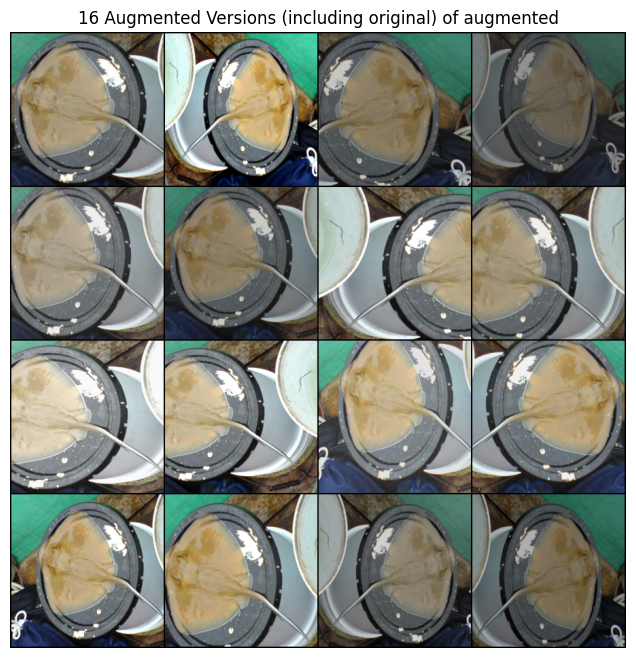

In [27]:
show_augmented_images(aug_dataset, num_images=16)

In [29]:
with torch.no_grad():
    images, labels = next(iter(dataloader))
    print(len(images))
    images = images.to(DEVICE)
    outputs = clean_coop_net(images)
    top_outputs, id_aug = select_confident_samples(outputs, .1)

64


In [30]:
print(id_aug)

tensor([ 5, 20, 50, 61, 58, 60], device='cuda:0')


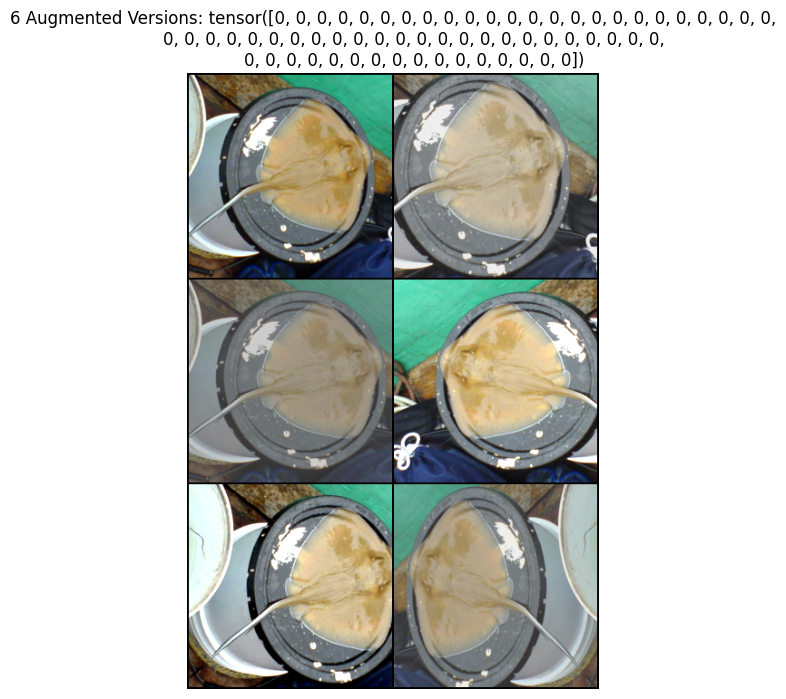

In [31]:
show_augmented_images_from_id_list(aug_dataset, id_aug, title = labels)

In [ ]:
print(len(imagenet_a))

7500


In [ ]:
def test_step_tpt(net, dataset, cost_function, log_writer, num_aug = 63):
    """ 
    @param net takes a OurClip model type 
    """
    samples = 0.0
    cumulative_loss = 0.0
    cumulative_accuracy = 0.0

    # Set the network to evaluation mode
    net.eval()

    # Disable gradient computation (we are only testing, we do not want our model to be modified in this step!)
    pbar = tqdm(dataset, desc="TPT_testing", position=0,
                leave=True, total=len(dataset))
    with torch.no_grad():
        # Iterate over the test set
        for (image, target) in splitted_datasets[2]:
            
            aug_data = AugmentSingleSampleDataset(image, sample_idx, num_augments=num_aug)
            # Load data into GPU
            aug_data = aug_data.to(DEVICE)
            target = target.to(DEVICE)

            images, labels = next(iter(dataloader))
            print(len(images))
            images = images.to(DEVICE)
            outputs = clean_coop_net(images)
            top_outputs, id_aug = select_confident_samples(outputs, .1)
            avg_elements = compute_avg_entropy(top_outputs)
            # Loss computation
            loss = cost_function(avg_elements, target)

            # Fetch prediction and loss value
            samples += inputs.shape[0]
            # Note: the .item() is needed to extract scalars from tensors
            cumulative_loss += loss.item()
            _, predicted = outputs.max(1)

            # Compute accuracy
            cumulative_accuracy += predicted.eq(target).sum().item()

            pbar.set_postfix(test_acc=cumulative_accuracy / samples * 100)
            pbar.update(1)

    return cumulative_loss / samples, cumulative_accuracy / samples * 100

SyntaxError: non-default argument follows default argument (253547986.py, line 1)

In [ ]:
def tpt_test(net= OurCLIP(),datasets, run_name="tpt1", num_aug = 6):
    
    # Create a logger for the experiment
    log_writer = SummaryWriter(log_dir=f"runs/{run_name}")

    print("Turning off all gradients in the net")
    for name, param in net.named_parameters():
            param.requires_grad_(False)
            print(f"{name} has requires_grad at {param.requires_grad} ")


    # Define the cost function
    cost_function = get_cost_function()

    print("Test tpt:")
    test_loss, test_accuracy = test_step_tpt(net, datasets[2], cost_function, log_writer, num_aug = num_aug)

    """     log_values(log_writer, epochs, train_loss, train_accuracy, "train")
    log_values(log_writer, epochs, val_loss, val_accuracy, "validation")
    log_values(log_writer, epochs, test_loss, test_accuracy, "test")
    print(
        f"\tTraining loss {train_loss:.5f}, Training accuracy {train_accuracy:.2f}")
    print(
        f"\tValidation loss {val_loss:.5f}, Validation accuracy {val_accuracy:.2f}")
    print(f"\tTest loss {test_loss:.5f}, Test accuracy {test_accuracy:.2f}") """

    # Closes the logger
    log_writer.close()

In [ ]:
tpt_test(clean_coop_net, splitted_datasets)